In [ ]:
# Imports
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# 🛠️ Import external resources
sys.path.append(os.path.abspath(".."))
from lists import likert_mapping, likert_questions

# Load Excel data
file_path = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# Drop rows with missing values in the relevant Likert-scale questions
df_clean = df.dropna(subset=likert_questions).copy()

# Replace Likert-scale answers with numeric values
df_numeric = df_clean[likert_questions].replace(likert_mapping)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# Show PCA loadings (influence of each question on the principal components)
components = pd.DataFrame(pca.components_, columns=likert_questions)
print("📊 PCA loadings – influence of questions on components:")
print(components.T)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Add clusters back to cleaned DataFrame
df_clean["Cluster"] = clusters

# Create a PCA scatter plot with clusters
df_plot = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df_plot["Cluster"] = clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=100)
plt.title("PCA of Likert-scale AI Attitudes (KMeans Clustering)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True)
plt.tight_layout()
plt.show()

# Mean values per cluster (how the clusters answered each Likert question)
cluster_means = df_clean.groupby("Cluster")[likert_questions].apply(
    lambda x: x.replace(likert_mapping).mean()
).round(2)

print("\n📈 Mean scores of Likert questions per cluster:")
print(cluster_means.T)

# Plot heatmap of cluster means
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Cluster Profiles based on Likert-scale Answers")
plt.xlabel("Cluster")
plt.ylabel("Question")
plt.tight_layout()
plt.show()


📊 PCA loadings – influence of questions on components:
                                     PC1       PC2
Use AI school and freetime      0.427194 -0.222654
Frequency of use education      0.389607 -0.188654
Frequency of use everyday life  0.283004 -0.036868
Usefullness AI                  0.407236  0.003722
Deal with AI                    0.315987 -0.110811
Understanding AI                0.125531 -0.033071
Reliability AI                  0.290417  0.284544
Teachers preparing lessons      0.130096  0.580075
Teachers giving grades          0.141870  0.574230
Mates using AI                  0.247891 -0.346598
Help of AI                      0.348323  0.181017


c:\Users\tills\Bachelor-Code\Analyse_Files\Helper_funtions.py:124: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_mapped = df[internet_cols].replace(Internet_terms_mapping)
C:\Users\tills\AppData\Local\Temp\ipykernel_18336\3343903343.py:45: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_numeric = df_clean[likert_questions].replace(likert_mapping)


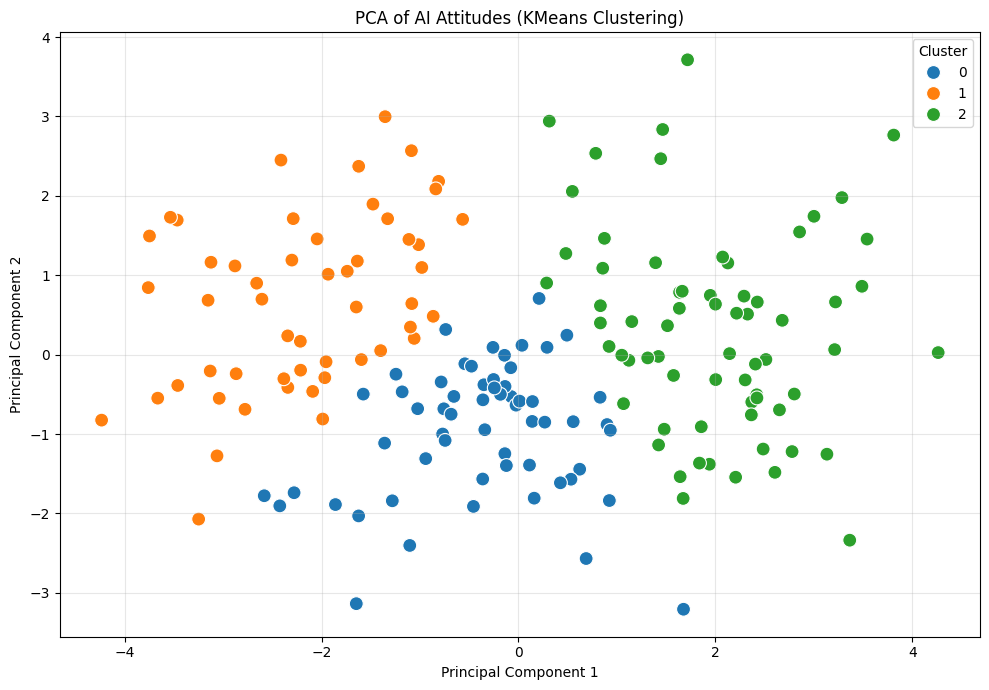

Help of AI                        21
Frequency of use everyday life    10
Frequency of use education        10
Usefullness AI                    10
Mates using AI                     2
Use AI school and freetime         0
Deal with AI                       0
Reliability AI                     0
Understanding AI                   0
Teachers giving grades             0
Teachers preparing lessons         0
dtype: int64

📈 Mean scores of Likert questions per cluster:
Cluster                            0     1     2
Use AI school and freetime      3.92  2.65  4.56
Frequency of use education      3.32  2.33  4.18
Frequency of use everyday life  2.44  2.13  3.31
Usefullness AI                  3.92  3.31  4.71
Deal with AI                    3.86  3.25  4.40
Understanding AI                3.02  3.00  3.53
Reliability AI                  3.19  3.08  3.91
Teachers preparing lessons      2.22  2.75  3.04
Teachers giving grades          1.19  1.90  2.28
Mates using AI                  4.19  3.40

C:\Users\tills\AppData\Local\Temp\ipykernel_18336\3343903343.py:87: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  lambda x: x.replace(likert_mapping).mean()


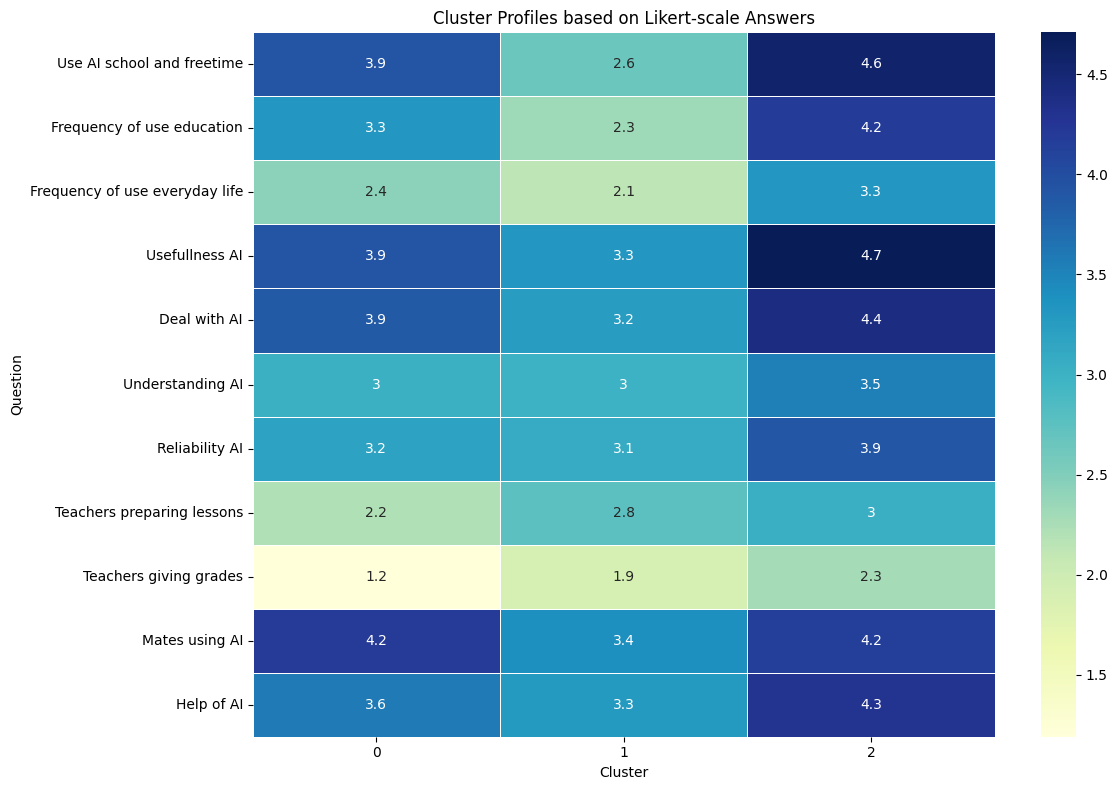

In [ ]:
# Imports
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Import external resources
sys.path.append(os.path.abspath(".."))
from lists import likert_mapping, likert_questions
from Helper_funtions import (
    calculate_Internet_terms_understanding_score,
    group_internet_understanding,
)

# Load Excel data
file_path = os.path.join("..", "Data", "Fertige Tabelle.xlsx")
df = pd.read_excel(file_path)
df.columns = df.columns.str.strip()

# --- Create the two features ---
df = calculate_Internet_terms_understanding_score(df)
df = group_internet_understanding(df)

# Keep only rows that have *all* likert features present
df_clean = df.dropna(subset=likert_questions).copy()

# Replace Likert-scale labels with numeric values where needed.
# Numeric columns (like True_False_Score) will pass through unchanged.
df_numeric = df_clean[likert_questions].replace(likert_mapping)

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_numeric)

# Apply PCA
pca = PCA(n_components=2, random_state=42)
pca_result = pca.fit_transform(scaled_data)

# Show PCA loadings (influence of each question on the principal components)
components = pd.DataFrame(pca.components_, columns=likert_questions, index=["PC1", "PC2"])
print("📊 PCA loadings – influence of questions on components:")
print(components.T)

# Apply KMeans clustering
kmeans = KMeans(n_clusters=3, n_init=10, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Add clusters back to cleaned DataFrame
df_clean["Cluster"] = clusters

# Create a PCA scatter plot with clusters
df_plot = pd.DataFrame(pca_result, columns=["PC1", "PC2"])
df_plot["Cluster"] = clusters

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="Cluster", palette="tab10", s=100)
plt.title("PCA of AI Attitudes (KMeans Clustering)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", loc="best")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# Mean values per cluster (how the clusters answered each Likert question)
cluster_means = df_clean.groupby("Cluster")[likert_questions].apply(
    lambda x: x.replace(likert_mapping).mean()
).round(2)

print("\n📈 Mean scores of Likert questions per cluster:")
print(cluster_means.T)

# Plot heatmap of cluster means
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_means.T, annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Cluster Profiles based on Likert-scale Answers")
plt.xlabel("Cluster")
plt.ylabel("Question")
plt.tight_layout()
plt.show()


In [2]:
df_numeric[likert_questions].corr()

,Use AI school and freetime,Frequency of use education,Frequency of use everyday life,Usefullness AI,Deal with AI,Understanding AI,Reliability AI,Teachers preparing lessons,Teachers giving grades,Mates using AI,Help of AI
Use AI school and freetime,1.000000,0.737866,0.488765,0.599740,0.392920,0.066994,0.311862,0.087209,0.005487,0.447753,0.401150
Frequency of use education,0.737866,1.000000,0.247005,0.495048,0.387656,0.059792,0.238860,0.100459,0.077120,0.421281,0.401297
Frequency of use everyday life,0.488765,0.247005,1.000000,0.480049,0.256107,0.152073,0.119831,0.087591,0.205055,0.180268,0.130101
Usefullness AI,0.599740,0.495048,0.480049,1.000000,0.399041,0.090696,0.421178,0.156599,0.122872,0.212657,0.478764
Deal with AI,0.392920,0.387656,0.256107,0.399041,1.000000,0.388774,0.228866,0.055725,0.051707,0.220552,0.335004
Understanding AI,0.066994,0.059792,0.152073,0.090696,0.388774,1.000000,0.107459,0.018028,0.048826,0.081113,0.069981
Reliability AI,0.311862,0.238860,0.119831,0.421178,0.228866,0.107459,1.000000,0.186359,0.287143,0.110273,0.505417
Teachers preparing lessons,0.087209,0.100459,0.087591,0.156599,0.055725,0.018028,0.186359,1.000000,0.469622,-0.142757,0.235027
Teachers giving grades,0.005487,0.077120,0.205055,0.122872,0.051707,0.048826,0.287143,0.469622,1.000000,0.000883,0.218986
Mates using AI,0.447753,0.421281,0.180268,0.212657,0.220552,0.081113,0.110273,-0.142757,0.000883,1.000000,0.242111


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from IPython.display import display, HTML

# ------------ distribution of demographics of clusters, percentage is based on the value
# e.g., 20% of students of 17 year old's in cluster 1------------

#  Setup 
sys.path.append(os.path.abspath(".."))
from answer_categories import question_orders
from lists import multiple_choice_questions, demographic_columns

# File paths
cluster_file = os.path.join("..", "Data", "Clustered_Students.xlsx")
full_data_file = os.path.join("..", "Data", "Fertige Tabelle.xlsx")

# Load full dataset (needed for category-level reference)
df_total = pd.read_excel(full_data_file)
df_total.columns = df_total.columns.str.strip()

# Load all clusters (each sheet = one cluster)
xls = pd.read_excel(cluster_file, sheet_name=None)

# Set plot style
sns.set(style="whitegrid")

# --------- Loop through clusters ----------
for sheet_name, cluster_df in xls.items():
    print(f"\n📊 Inverted Demographic Analysis in {sheet_name}:")

    for column in demographic_columns:
        if column not in cluster_df.columns or column not in df_total.columns:
            print(f"⚠️ Column '{column}' not found. Skipping.")
            continue

        # --- Handle Multiple Choice ---
        if column in multiple_choice_questions:
            # Explode in both cluster and full data
            cluster_exp = (
                cluster_df[[column]].dropna()
                .assign(**{column: cluster_df[column].str.split(",")})
                .explode(column)
            )
            cluster_exp[column] = cluster_exp[column].str.strip()

            total_exp = (
                df_total[[column]].dropna()
                .assign(**{column: df_total[column].str.split(",")})
                .explode(column)
            )
            total_exp[column] = total_exp[column].str.strip()

            cluster_series = cluster_exp[column]
            total_series = total_exp[column]
        else:
            # For single-choice: treat normally
            cluster_series = cluster_df[column].dropna().astype(str)
            total_series = df_total[column].dropna().astype(str)

        # --- Counts ---
        total_counts = total_series.value_counts()
        cluster_counts = cluster_series.value_counts()

        # Calculate counts & percentages
        absolute_counts = counts_series.value_counts(dropna=False)
        relative_percent = counts_series.value_counts(normalize=True, dropna=False) * 100

        # Create summary DataFrame for display
        summary_df = pd.DataFrame({
            "Count": absolute_counts,
            "Percentage": relative_percent.round(1)
        })

        # Apply question_orders if available
        if column in question_orders:
            ordered_cats = [str(cat) for cat in question_orders[column] if str(cat) in summary_df.index]
            summary_df = summary_df.reindex(ordered_cats)

        print(f"\n{column} distribution in {sheet_name}:")
        print(summary_df)

        # Plot
        plt.figure(figsize=(8, 4))
        sns.barplot(
            x=summary_df.index, 
            y=summary_df["Percentage"], 
            palette="Set2"
        )
        plt.title(f"{column} in {sheet_name} (percent)")
        plt.xlabel(column)
        plt.ylabel("Percentage of students")
        plt.xticks(rotation=45)
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.show()



        # --- Percentage of each category in the cluster (based on total dataset) ---
        percent_in_cluster = (cluster_counts / total_counts * 100).round(1)
        percent_in_cluster = percent_in_cluster.fillna(0)

        # --- Combine into display table ---
        summary_df = pd.DataFrame({
            "Total": total_counts,
            f"{sheet_name} Count": cluster_counts,
            f"{sheet_name} % of Total": percent_in_cluster
        }).fillna(0)

        # --- Apply order if defined ---
        if column in question_orders:
            ordered = [str(val) for val in question_orders[column] if str(val) in summary_df.index]
            summary_df = summary_df.reindex(ordered)
        elif summary_df.index.to_series().str.isnumeric().all():
            summary_df = summary_df.sort_index(key=lambda x: x.astype(int))

        # --- Print table ---
        styled_table = summary_df.style.set_caption(f"{column} – {sheet_name}").format(precision=1)
        display(HTML(styled_table.to_html()))

        # Show table horizontally with styling
        styled_table = summary_df.style.set_caption(f"{column} – {sheet_name}").format(precision=1)
        display(HTML(styled_table.to_html()))

        # --- Plotting ---
        plt.figure(figsize=(8, 4))
        sns.barplot(
            x=summary_df.index, 
            y=summary_df[f"{sheet_name} % of Total"], 
            palette="Set2"
        )
        plt.title(f"{column} – % of total in {sheet_name}")
        plt.xlabel(column)
        plt.ylabel("Percent of total students")
        plt.xticks(rotation=45)
        plt.ylim(0, 100)
        plt.tight_layout()
        plt.show()